# Project 1 - Query Project

### As a data scientist at Lyft Bay Wheels, I have initially performed data exploration on the static sanfrancisco dataset through Google BigQuery to better understand the situation around bikeshare stations, bikeshare statuses, and bikeshare trips within the area of San Francisco and migrated the final queries onto this Jupyter Notebook to provide data that supports my recommendations in an effort to increase ridership for the company. After performing some data analysis against the bikeshare_stations, bikeshare_status, and bikeshare_trips static tables in the san_francisco dataset, below are the recommendations to increase ridership along with the the data analysis performed to support my claims:

## Imports:

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Import, Cleaning, and Analysis:

The first query below was created to provide a list of the top 10 starting stations that have the lowest number of trips. Since a bike trip starts from a selected station, the intent was to take a look at which starting stations have the lowest count of bike trips so that a recommendation could be provided in order to bring up the number of rides from that starting station. Based on the results, the top 10 starting point stations with the lowest number of trips would be Clay at Battery, Market at 10th, 2nd at South Park, Evelyn Park and Ride, Embarcadero at Vallejo, Broadway St at Battery St, Embarcadero at Bryant, Grant Avenue at Columbus Avenue, St James Park, and Spear at Folsom. It is also worth mentioning that even though I could've used the bigquery magic command to create a name for the table just like the other follow-up data frames, I have decided to create at least one csv output file to demonstrate capabilities of being able to import and read csv files within the jupyter notebook as well.

In [36]:
! bq query --use_legacy_sql=false --format=csv 'SELECT start_station_name, number_of_trips FROM bike_trip_data.numberoftrips WHERE number_of_trips <= 105 ORDER BY number_of_trips ASC LIMIT 10' > startstation_trips.csv

Waiting on bqjob_r7281542985270cc5_00000179d467e114_1 ... (0s) Current status: DONE   


In [37]:
startingstations_with_lowest_trips = pd.read_csv('startstation_trips.csv')

startingstations_with_lowest_trips

,start_station_name,number_of_trips
0,Clay at Battery,101
1,Market at 10th,101
2,2nd at South Park,102
3,Evelyn Park and Ride,102
4,Embarcadero at Vallejo,102
5,Broadway St at Battery St,102
6,Embarcadero at Bryant,102
7,Grant Avenue at Columbus Avenue,103
8,St James Park,103
9,Spear at Folsom,103


The second query below was created to take a look at the amount of bike trips per duration of hours. It is important to note the huge difference in bike trip counts within less than one hour compared to 1 hour+. There was a total of 936,280 bike trips that had a duration of less one hour compared to 26,500 trips in between 1 hour and 2 hours. As shown in the query results, a majority of the bike trips were less than a hour which shows that most trips are very short. It is also worth mentioning that I have created the following view called 'trips_1' in Google BigQuery in order convert the durations into minutes/hours and also performed "feature engineering" to create some new columns that were easier to work with:

```sql
select
    trip_id,
    CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes,
    CAST(ROUND(duration_sec / 3600.0) AS INT64) AS duration_hours_rounded,
    EXTRACT(DAYOFWEEK from start_date) AS dow_int,
    CASE EXTRACT(DAYOFWEEK FROM start_date)
        WHEN 1 THEN "Sunday"
        WHEN 2 THEN "Monday"
        WHEN 3 THEN "Tuesday"
        WHEN 4 THEN "Wednesday"
        WHEN 5 THEN "Thursday"
        WHEN 6 THEN "Friday"
        WHEN 7 THEN "Saturday"
        END AS dow_str,
    EXTRACT(HOUR FROM start_date) AS start_hour,
    start_date,
    end_date,
    start_station_name,
    start_station_id,
    end_station_name,
    end_station_id,
    bike_number,
    zip_code,
    subscriber_type
from `bigquery-public-data.san_francisco.bikeshare_trips`
```

In [38]:
%%bigquery biketrips_duration_hours

SELECT duration_hours_rounded, count(*) FROM `bike_trip_data.trips_1` GROUP BY duration_hours_rounded ORDER BY 1 LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.34rows/s]


In [39]:
biketrips_duration_hours

,duration_hours_rounded,f0_
0,0,936280
1,1,26500
2,2,7924
3,3,4217
4,4,2643
5,5,1692
6,6,1110
7,7,757
8,8,572
9,9,251


The third query below was created to take a look at which day of the week had the lowest count of bike trips. As shown in the results, the day of week with the lowest count of bike trips was Sunday with 46,336 trips and next was Saturday with 54,333 trips which should that weekends usually have a lower number of bike trips compared to weekdays. I have also created the following view called trips_2 out of the trips_1 view in order to specifically take a look at which bike trips had a duration in between 5 to 20 minutes:

```sql
select *
from `bike_trip_data.trips_1`
where duration_minutes >= 5
        and duration_hours_rounded <= 20
```

In [40]:
%%bigquery dayofweek_biketrips

SELECT dow_int, dow_str, count(*) FROM `bike_trip_data.trips_2` GROUP BY dow_int, dow_str ORDER BY 1

Downloading: 100%|██████████| 7/7 [00:01<00:00,  5.14rows/s]


In [41]:
dayofweek_biketrips

,dow_int,dow_str,f0_
0,1,Sunday,46336
1,2,Monday,144920
2,3,Tuesday,157046
3,4,Wednesday,154204
4,5,Thursday,151062
5,6,Friday,137194
6,7,Saturday,54333


The fourth query below was created to view which landmarks had the most bikes available on a frequent basis. Initially, I have scoped the results to show top 10 results but then wanted to further resolve my curiosity by expanding the results limit to 20, 30, 40, and then 50 results. As you can see from the top 10 of the results, San Francisco showed up 5 times whereas San Jose showed up 3 times and Redwood city show up 2 times. When I further visualized the data through a seaborn barplot, San Francisco happened to still be number 1 in terms of the most amount of bikes available on a frequent basis compared to San Jose as 2nd place, Redwood City as 3rd place, Mountain View as 4th place, and Palo Alto as 5th place.

In [42]:
%%bigquery landmark_bikesavailable

SELECT distinct(bikeshare_stations.landmark), bikeshare_status.bikes_available FROM bigquery-public-data.san_francisco.bikeshare_status INNER JOIN bigquery-public-data.san_francisco.bikeshare_stations ON bikeshare_status.station_id=bikeshare_stations.station_id
ORDER BY bikes_available DESC LIMIT 50

Downloading: 100%|██████████| 50/50 [00:01<00:00, 31.55rows/s]


In [43]:
landmark_bikesavailable

,landmark,bikes_available
0,San Francisco,29
1,San Francisco,28
2,San Francisco,27
3,San Jose,27
4,Redwood City,26
5,San Jose,26
6,San Francisco,26
7,Redwood City,25
8,San Francisco,25
9,San Jose,25


The fifth query below was created to view which stations had the lowest count of usage. Based on the query results, Station 88 had the lowest usage with a count of only 38 trips compared to Station 91 with 125 trips, Station 89 with 157 trips, and so on. I have further visualized these results through a seaborn barplot in the data visualization section and added a cut-off line in red in order to view which stations had lower than 20,000 trips so that recommendations could be provided for those specific stations. It is also worth mentioning that I have also used the trips_2 view for this analysis and unioned the count for starting stations and ending stations.

In [44]:
%%bigquery stationid_tripcount

SELECT station_id, sum(trip_count)
FROM
(
SELECT start_station_id as station_id, count(*) as trip_count
FROM `bike_trip_data.trips_2`
GROUP BY start_station_id
UNION ALL
SELECT end_station_id as station_id, count(*) as trip_count
FROM `bike_trip_data.trips_2`
GROUP BY end_station_id
)
GROUP BY station_id order by 2

Downloading: 100%|██████████| 74/74 [00:01<00:00, 47.82rows/s]


In [46]:
stationid_tripcount

,station_id,f0_
0,88,38
1,91,125
2,89,157
3,90,252
4,21,303
...,...,...
69,61,75276
70,60,84880
71,50,91345
72,69,99003


The sixth query below was created to answer the following Part 3 question: What are the 5 most popular trips that you would called "commuter trips"?

For this question, I have created a SQL query that selected the count of starting and ending stations that had a starting hour in between 6 and 9 as well as in between 16 and 19 so that only trips within the time ranges of commuting to work and leaving work were captured. I have limited the results to 5 so that only the top 5 were provided. Also for better visualization purposes, I have updated the dataframe in order to group both the starting station and ending station into an additiona column rather than displaying both columns seperately in my seaborn barplot.

In [49]:
%%bigquery commuter_trips

SELECT start_station_name, end_station_name, count(*)
FROM `bike_trip_data.trips_2`
WHERE start_station_name <> end_station_name
    and dow_int <> 1
    and dow_int <> 7
    and (start_hour >= 6 and start_hour <= 9) or (start_hour >= 16 and start_hour <= 19)
GROUP BY start_station_name, end_station_name
ORDER BY 3 desc
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.23rows/s]


In [50]:
commuter_trips['start_to_end_station'] = commuter_trips['start_station_name'] + ' to ' + commuter_trips['end_station_name']

In [21]:
commuter_trips

,start_station_name,end_station_name,f0_,start_to_end_station
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5700,Harry Bridges Plaza (Ferry Building) to 2nd at...
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5449,2nd at Townsend to Harry Bridges Plaza (Ferry ...
2,Embarcadero at Sansome,Steuart at Market,5194,Embarcadero at Sansome to Steuart at Market
3,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),5166,San Francisco Caltrain (Townsend at 4th) to Ha...
4,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4961,Embarcadero at Folsom to San Francisco Caltrai...


Additionally, below are some other sql queries that were only ran in order to better understand the sanfrancisco dataset but weren't added to the data visualization recommendations section.

In [53]:
%%bigquery

#SQL Query to answer the question of which docking stations have less than a total of 15 dock counts?
#Based on the results, the docking stations with less than a total of 15 dock counts would be Santa Clara at Almaden, Cowper at University, University and Emerson, and Castro Street and El Camino Real.

SELECT name
FROM `bigquery-public-data.san_francisco.bikeshare_stations`
WHERE dockcount < 15

Downloading: 100%|██████████| 4/4 [00:01<00:00,  2.65rows/s]


,name
0,Santa Clara at Almaden
1,Cowper at University
2,University and Emerson
3,Castro Street and El Camino Real


In [59]:
%%bigquery

#SQL Query to answer the question of what are the count of bike trips that have a duration of less than 5 minutes?

#Based on the results, there were 220,374 bike trips that had a duration of less than 5 minutes which shows that a majority of bike trips are very short.

SELECT count(*) FROM `bike_trip_data.trips_1` WHERE duration_minutes <= 5

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.58s/rows]


,f0_
0,220374


In [61]:
%%bigquery

#SQL Query to answer the question of what are the count of bike trips that have a duration of less than 10 minutes?

#Based on the results, there were 628,8444 bike trips that had a duration of less than 10 minutes which shows that a majority of bike trips are very short.

SELECT count(*) FROM `bike_trip_data.trips_1` WHERE duration_minutes <= 10

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.50s/rows]


,f0_
0,628444


## Data Visualization and Recommendations:

#### Visualization for count of bike trips that had a duration of less than 1 hour compared to 1 hour+

Text(0, 0.5, 'Hour')

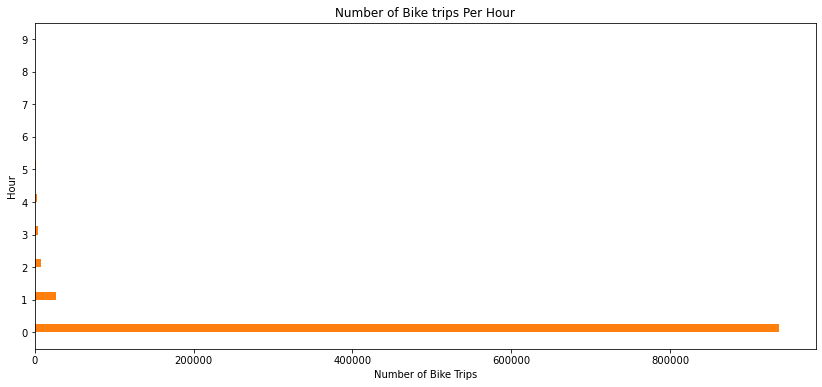

In [73]:
biketrips_duration_hours.plot(kind='barh', figsize=[14,6], legend=None)

plt.title('Number of Bike trips Per Hour')
plt.xlabel('Number of Bike Trips')
plt.ylabel('Hour')

#### Recommendation:

As you can see, the largest count of bike trips are within 0 to 1 hour which means that most customers are riding the bikes for a very short amount of time whether it'd be only to ride for commute and back or just to move from a close distance of location A to location B. In order to increase the duration of bike trips, I would like to recommend a point system that would allow customers to receive a number of points for every additional hour that is ridden within a single bike trip. For every additional hour, the customer would receive a number of point(s) that matches the amount of hour(s). For example, 1 additional hour would lead to 1 point, 2 additional hours would lead to 2 points, 3 additional hours would lead to 3 points, and so on. Each point would equal 5 dollars that could be spent on the next bike trip but also making sure that there is a cap of only receiving 20 points per month so that customers aren't always riding the bikes for free. This would increase the duration of bike trips due to incentivizing the bike trips through a fair and equal point system.

#### Visualization for count of starting stations with the lowest number of trips

Text(0.5, 1.0, 'Count of Starting Stations with Lowest Number of Trips')

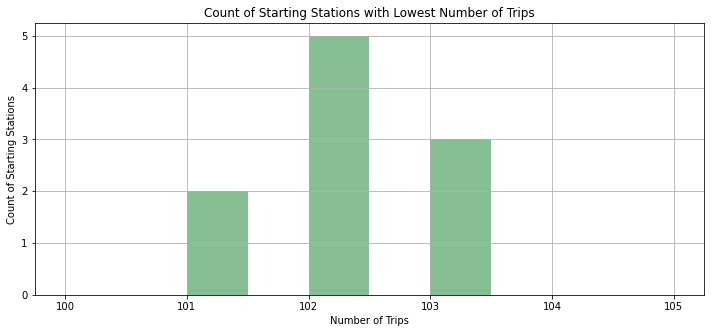

In [78]:
startingstations_with_lowest_trips.number_of_trips.hist(figsize=(12,5), color='#86bf91', align='mid', range=[100, 105])
plt.ylabel('Count of Starting Stations')
plt.xlabel('Number of Trips')
plt.title('Count of Starting Stations with Lowest Number of Trips')

#### Recommendation:

As you can see, there are 2 starting stations (Clay at Battery / Market at 10th) that have a total of only 101 bike trips, 5 starting stations (South Park / Evelyn Park and Ride / Embarcadero at Vallejo / Broadway St at Battery St / Embarcadero at Bryant) with a total of only 102 bike trips, and 3 starting stations (Grant Avenue at Columbus Avenue / St James Park / Spear at Folsom) that have a total of only 103 bike trips. The number of trips were considered very low at these 10 stations compared to other starting stations that had over thousands of trips with leads to the recommendation of initially providing a special discount of 20% at these 10 starting station locations. This would at least increase the amount of bike trips within these locations and based on how the results turn out, the discount could reduce to 10% after a 3-month cycle and back down to the regular price after another 3-month cycle once regular customers are captured to be using bikes at these starting stations on a regular basis.

#### Visualization for count of bike trips per day of the week

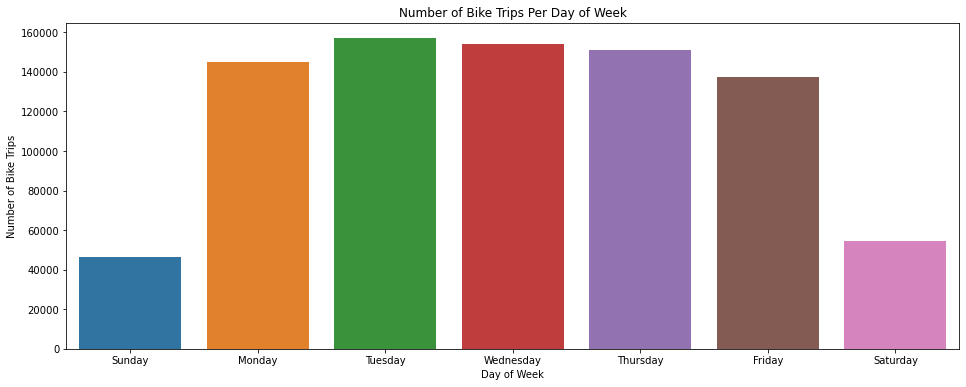

In [79]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='dow_str', y='f0_', data=dayofweek_biketrips)

ax.set(xlabel='Day of Week', ylabel='Number of Bike Trips', title='Number of Bike Trips Per Day of Week')
plt.show()

#### Recommendation:

As you can see, the number of bike trips are lowest on the weekends for Sunday with a count of 46,336 and Saturday with a count of 54,333. Since the weekdays seem to have a steady number of bike trips, I would recommend offering a weekend promotion similar to how NYC MTA LIRR promotes City Tickets at a discounted price of more than half the regular price on weekends. It would be reasonable to set the weekend promotion at a 60% discount in order to initially see how the number of bike trips fluctuates on weekends for the next 6 months and then decrease the weekend pass discount to 50% once the number of bike trips increases on both Saturday and Sunday.

#### Visualization for the number of bikes available per landmark

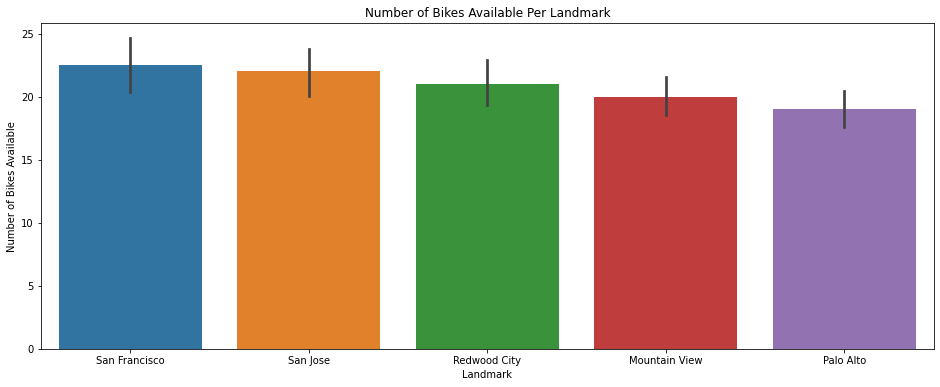

In [80]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='landmark', y='bikes_available', data=landmark_bikesavailable)

ax.set(xlabel='Landmark', ylabel='Number of Bikes Available', title='Number of Bikes Available Per Landmark')
plt.show()

#### Recommendation

As you can see, San Francisco has the highest number of bikes available on average compared to other landmarks such as Mountain View and Palo Alto. Since the city offers many opportunities for people to commute through other means of travel besides car, I would like to recommend promoting an exclusive membership for customers in San Francisco that would allow customers to obtain the first 3 months free if an annual membership is selected. Since San Francisco has been ranked the 2nd best bike friendly city in the country, it would be reasonable to take advantage of the landscape by also partnering with cycling apps that provide fitness metrics for those in the city who are increased in staying healthy through means of cycling. With the hopes of allowing customers to choose biking over other means of travel, this would allow customers to eventually get used to riding bicycles as their primary means of travel but also utilize the service to meet their health goals.

#### Visualization for count of trips per station

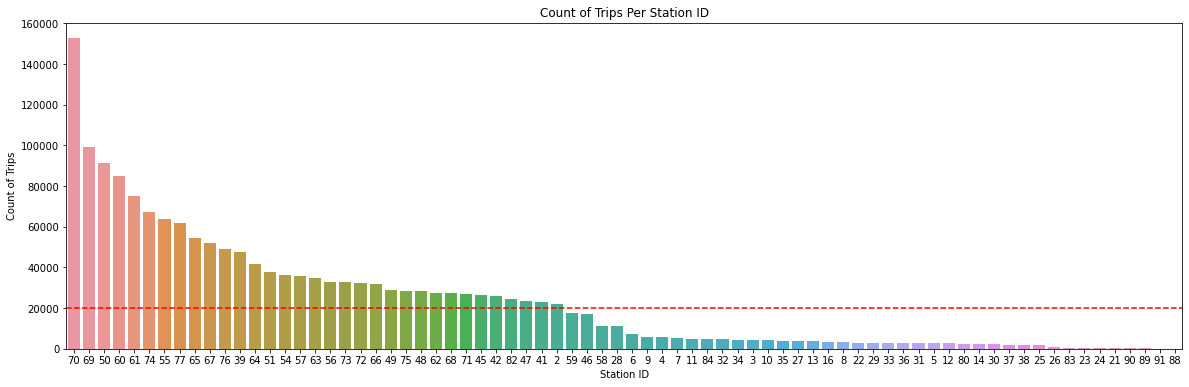

In [82]:
stationid_tripcount

plt.figure(figsize=(20, 6))
ax = sns.barplot(x='station_id', y='f0_', data=stationid_tripcount, order=stationid_tripcount.sort_values('f0_',ascending = False).station_id)

ax.set(xlabel='Station ID', ylabel='Count of Trips', title='Count of Trips Per Station ID')
ax.axhline(20000, ls='--', c='red')
plt.show()

#### Recommendation:

As you can see, there are a certain number of stations that have very low trip counts (e.g. 59, 46, 58, 28, and 6) compared to stations with the highest trip counts (e.g. 70, 69, 50, 60, and 61). To address the issue of low trip counts starting with Station IDs that have less than 20000 counts, I would like to recommend the same incentive as the first recommendation with implementing a point system but instead with a caveat which would be providing customers with double the points per ride for each additional hour. For example, if 1 point and 2 points are given for 1 and 2 additional hours respectively, 2 points and 4 points would be given for each 1 and 2 additional hours respectively for any station that has lower than 20,000 bike trips. This would allow users to be not only be motivated with using bikes from one ride into the next with their accumulated points but also increase the duration per bike trip as well so that customers can gradually feel more accustomed to using bikes at those stations. In addition, it would be reasonable to set up marketing campaigns within a few miles radius at each of these stations to promote the new incentives, especially for citizens who happen to need an efficient means of traveling or those who happen to live nearby at those specific stations (e.g. Stations 59,46,58,28,6...89,91,88).

#### Visualization for Top 5 Commuter Trips

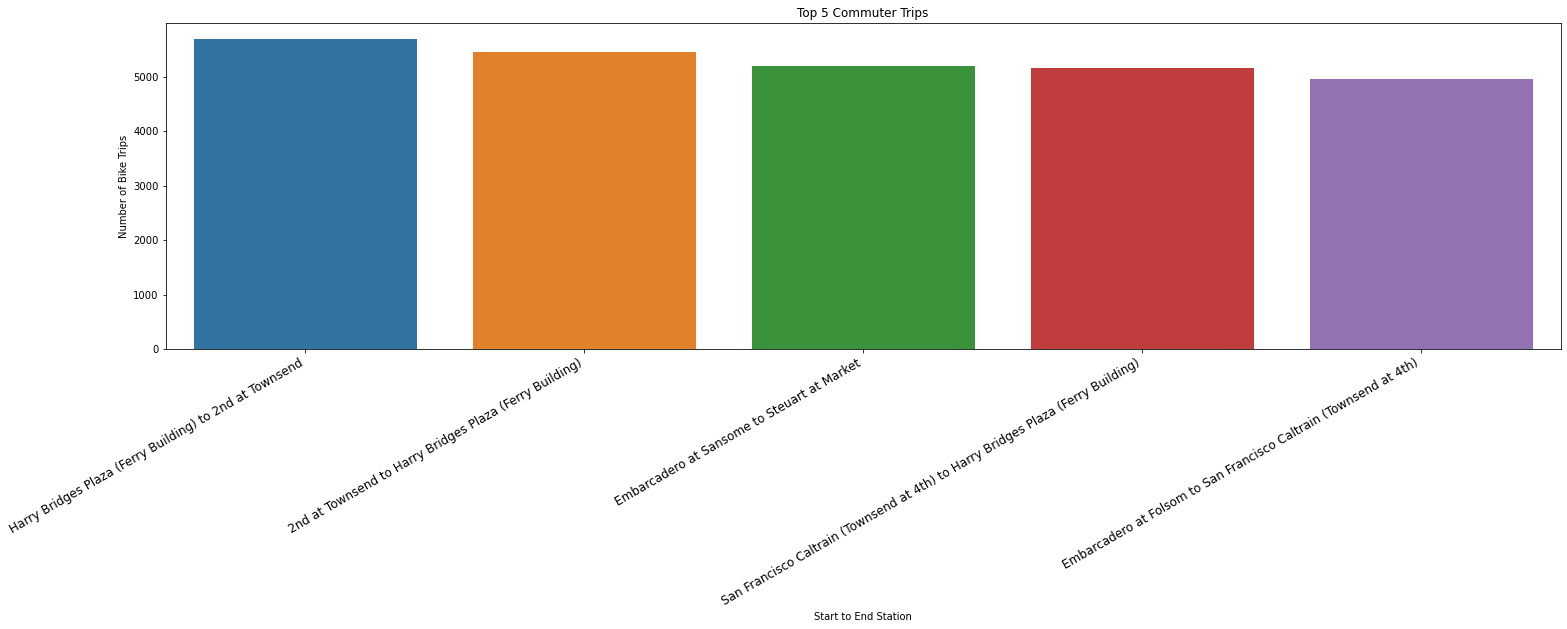

In [33]:
plt.figure(figsize=(25, 6))
ax = sns.barplot(x='start_to_end_station', y='f0_', data=commuter_trips)

plt.xticks(
    rotation=30, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)

ax.set(xlabel='Start to End Station', ylabel='Number of Bike Trips', title='Top 5 Commuter Trips')
plt.show()

In order to also answer the Part 3 Question of "What are the 5 most popular trips that you would call commuter trips?", I have collected a list of the total count of bike trips for the starting stations and ending startions in my bike_trip_data.trips_2 view that had a starting hour in between 6 and 9 as well as 16 and 19. I have visualized the SQL query that was provided in the previous "Data Import, Cleaning, and Analysis" section to showcase that the following 5 trips were the most popular. As shown in the results, the 5 most popular trips would be in the following order:

<h5>1.) Harry Bridges Plaza (Ferry Building) to 2nd at Townsend with a count of 5700 trips</h5>
<h5>2.) 2nd at Townsend to Harry Bridges Plaza (Ferry Building) with a count of 5449 trips</h5> 
<h5>3.) Embarcadero at Sansome to Steuart at Market with a count of 5194 trips</h5>
<h5>4.) San Francisco Caltrain (Townsend at 4th) to Harry Bridges Plaza (Ferry Building) with a count of 5166 trips</h5> 
<h5>5.) Embarcadero at Folsom to San Francisco Caltrain (Townsend at 4th) with a count of 4961 trips</h5>

## Conclusion

As a result, I believe that the data analysis supports the recommendations provided and would hopefully increase overall rideship for Lyft Bay Wheels. Based on which recommendations are selected, I will make sure to continuously provide reports to analyze the metrics on whether bike trips happen to increase for the given scenario(s). Please feel free to directly contact me at azj5160@gmail.com if you have any questions with the recommendations.